In [0]:
from google.colab import files
uploaded = files.upload()

Saving data_meeting_text_amazon.json to data_meeting_text_amazon.json


In [0]:
import json
from pprint import pprint
import string
import nltk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import gensim
from sklearn.cluster import AgglomerativeClustering
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
cores = multiprocessing.cpu_count()

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def loadData(sentences_file):
  sentences=[]
  agendas=[]
  with open(sentences_file) as train_file:
    dict_train = json.load(train_file)

  for i in dict_train:
    sentences.append(i['sentence'])
  return sentences

In [0]:
def filterEmptyStrings(arr):
  arr = list(filter(None, arr))
  return arr

In [0]:
def filterFunc(arr,func):
  arr = list(map(func,arr))
  return arr

In [0]:
def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

In [0]:
def remove_stopwords(text):
  sw = stopwords.words('english')
  text = [word.lower() for word in text.split() if word.lower() not in sw]
  return " ".join(text)

In [0]:
def preprocessing(arr):
  arr=filterFunc(arr,remove_punctuation)
  arr=filterFunc(arr,remove_stopwords)
  arr=filterEmptyStrings(arr)
  return arr


In [0]:
def convertToVec(arr,vectorizer):
  X=vectorizer.fit_transform(arr)
  return X,vectorizer

In [0]:
def convertToDoc2Vec(arr):
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(arr)]
  model =Doc2Vec(documents,dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
  start_alpha=0.01
  infer_epoch=1000
  X=[]
  for d in arr:
    X.append( model.infer_vector(d, alpha=start_alpha, steps=infer_epoch) )
  return X

In [0]:
def clustering(n_clusters,X,sentences_test,model):
  y=model.fit_predict(X)

  clusters={}
  for i in range(0,len(y)):
    if(str(y[i]) not in clusters): clusters[str(y[i])]=[]
    clusters[str(y[i])].append(sentences_test[i])
  return clusters,y


In [0]:
def plot_graph(num_alg,num_approach,plot_dict):
  # fig, axs = plt.subplots(num_alg*num_approach,figsize=(17,25))
  # fig.subplots_adjust(hspace=1)
  i=0
  for key in plot_dict:
    sns.countplot(plot_dict[key]).set_title(key)
    i+=1

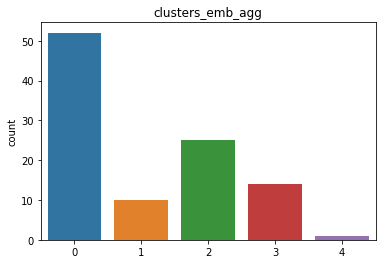

In [0]:
sentenceFile="data_meeting_text_amazon.json"

sentences=loadData(sentenceFile)
sentences_test=sentences
sentences=preprocessing(sentences)
num_clusters=5
predictions_dict={}


doc2Vec=convertToDoc2Vec(sentences)
agg= AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
# clusters_tfidf_agg,pred=clustering(num_clusters,tfidfVec.toarray(),sentences_test,agg)
# predictions_dict["clusters_tfidf_agg"]=pred
# clusters_count_agg,pred=clustering(num_clusters,countVec.toarray(),sentences_test,agg)
# predictions_dict["clusters_count_agg"]=pred
clusters_emb_agg,pred=clustering(num_clusters,doc2Vec,sentences_test,agg)
predictions_dict["clusters_emb_agg"]=pred

plot_graph(1,1,predictions_dict)

In [0]:
from google.colab import files
def download_json(technique,clusters):
  with open('clusters-'+technique+'.json', 'w') as fp:
    json.dump(clusters, fp)
  files.download('clusters-'+technique+'.json')
download_json('clusters_emb_agg',clusters_emb_agg)